In [39]:
from data_read import *
from odometry_functions_depthcompletion_dataset import *
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from scipy.optimize import least_squares
import os
import math
import matplotlib.pyplot as plt

In [44]:
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7,
                       useHarrisDetector=False)
lk_params = dict( winSize  = (15,15),
                  maxLevel = 6,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

num_frames = 5
data_loader=Data_load(input_line=64, frames=num_frames)
lidar_frames,gt_frames,img_frames,index_list=data_loader.read_frames(batch=1, if_removal=False, index = None )


## Using sparse lidar image as input

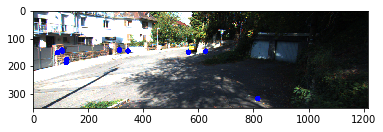

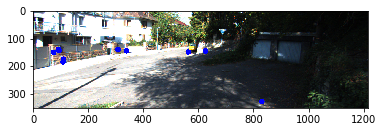

Total points :  10
Solution found :  True
T (from solvePnPRansac) : 
[[ 9.99997781e-01 -1.84204433e-03 -1.02187332e-03  1.67653473e-02]
 [ 1.84111709e-03  9.99997893e-01 -9.07583459e-04  1.14368597e-02]
 [ 1.02354298e-03  9.05700057e-04  9.99999066e-01 -4.57609464e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T (from scipy least_squares) : 
[[ 9.99997781e-01  1.84111913e-03  1.02353414e-03 -1.63178540e-02]
 [-1.84204634e-03  9.99997893e-01  9.05693306e-04 -1.09913913e-02]
 [-1.02186450e-03 -9.07576694e-04  9.99999066e-01  4.57636742e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


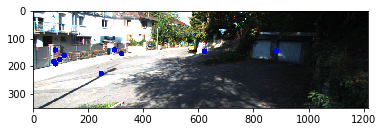

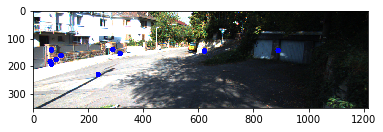

Total points :  10
Solution found :  True
T (from solvePnPRansac) : 
[[ 9.99997836e-01  2.05953681e-03 -2.92188015e-04  7.24369587e-03]
 [-2.05983349e-03  9.99997360e-01 -1.01872954e-03  3.67240803e-03]
 [ 2.90089133e-04  1.01932920e-03  9.99999438e-01 -4.61265445e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T (from scipy least_squares) : 
[[ 9.99997836e-01 -2.05983514e-03  2.90084306e-04 -7.10219978e-03]
 [ 2.05953848e-03  9.99997360e-01  1.01931125e-03 -3.21683382e-03]
 [-2.92183154e-04 -1.01871160e-03  9.99999438e-01  4.61271082e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


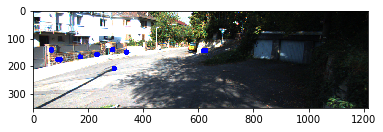

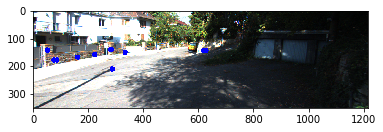

Total points :  10
Solution found :  True
T (from solvePnPRansac) : 
[[ 0.99999399  0.00306428 -0.001623    0.03942954]
 [-0.00306603  0.99999472 -0.00107816  0.01422526]
 [ 0.00161968  0.00108313  0.9999981  -0.44560956]
 [ 0.          0.          0.          1.        ]]
T (from scipy least_squares) : 
[[ 0.99999399 -0.00306603  0.00161971 -0.03866464]
 [ 0.00306428  0.99999472  0.00108313 -0.01386342]
 [-0.00162302 -0.00107816  0.9999981   0.44568801]
 [ 0.          0.          0.          1.        ]]


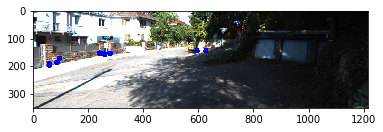

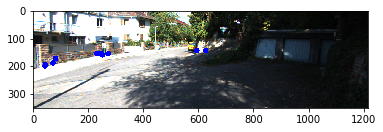

Total points :  10
Solution found :  True
T (from solvePnPRansac) : 
[[ 0.99999573  0.00201552 -0.00211462  0.01993593]
 [-0.00201979  0.99999592 -0.002021    0.03664741]
 [ 0.00211054  0.00202526  0.99999572 -0.44503155]
 [ 0.          0.          0.          1.        ]]
T (from scipy least_squares) : 
[[ 0.99999573 -0.00201979  0.00211056 -0.01892326]
 [ 0.00201552  0.99999592  0.00202526 -0.03578608]
 [-0.00211465 -0.002021    0.99999572  0.44514594]
 [ 0.          0.          0.          1.        ]]


In [45]:
frame_id = 0

scene=data_loader.img_path[index_list[0]].split('/')[5].split('_')[:3]
scene_date = scene[0]
camera_id = data_loader.img_path[index_list[0]].split('/')[-3]
for i in range(1,len(scene)) : 
    scene_date += '_' + scene[i]
K = get_calib_file(scene_date,camera_id) # eg: 2011_09_26, image_03

tc = torchCloud(K,lidar_frames.shape[1],lidar_frames.shape[2])

T_list = []

while (frame_id < num_frames-1):
    features = find_keypoints(img_frames[frame_id,:,:,:],lidar_frames[frame_id,:,:,0],feature_params)
    next_features, status, error = track_features(img_frames[frame_id,:,:,:],features,img_frames[frame_id+1,:,:,:],lk_params)
    features = features[status==1]
    next_features = next_features[status==1]

    image = np.copy(img_frames[frame_id,:,:,:])
    next_image = np.copy(img_frames[frame_id+1,:,:,:])
    for i in range(len(features)):
        cv2.circle(image,(features[i][0],features[i][1]),10,(0,0,255),-1)
        cv2.circle(next_image,(next_features[i][0],next_features[i][1]),10,(0,0,255),-1)

    plt.imshow(image)
    plt.show()

    plt.imshow(next_image)
    plt.show()

    pts_3d_1 = compute_3D_points(lidar_frames[frame_id,:,:,:],features,K)
    pts_2d_2 = []
    for i in range(len(features)):
        x = int(next_features[i,0])
        y = int(next_features[i,1])
        pts_2d_2.append([x,y])
    pts_2d_2 = np.asarray(pts_2d_2)
    print("Total points : ",len(pts_2d_2))
    P = np.hstack((K,np.zeros((3,1))))

    pts_3d_1 = np.expand_dims(pts_3d_1.astype(np.float32),axis=1)
    pts_2d_2 = np.expand_dims(pts_2d_2.astype(np.float32),axis=1)
    ret = cv2.solvePnPRansac(pts_3d_1,pts_2d_2,P[:3,:3],distCoeffs=None)

    print("Solution found : ",ret[0])

#     r = genEulerZXZMatrix(-ret[1][0][0],-ret[1][1][0],-ret[1][2][0])
#     transf_matrix = np.hstack((r,-ret[2]))
#     transf_matrix = np.vstack((transf_matrix,np.asarray([0,0,0,1])))

    r, _ = cv2.Rodrigues(ret[1])
    transf_matrix = np.hstack((r,ret[2]))
    transf_matrix = np.vstack((transf_matrix,np.array([0,0,0,1])))
    print("T (from solvePnPRansac) : ")
    print(transf_matrix)
    T_list.append(transf_matrix)
    
    pts_3d_1 = np.hstack( (np.squeeze(pts_3d_1), np.ones(( len(pts_3d_1),1) )))
    pts_2d_2 = np.hstack( (np.squeeze(pts_2d_2), np.ones(( len(pts_2d_2),1) )))

    dSeed = np.zeros(len(pts_3d_1))
    opt = least_squares(func,dSeed,method='lm',verbose=0,args=(pts_3d_1,pts_2d_2,P))
    R = genEulerZXZMatrix(opt.x[0],opt.x[1],opt.x[2])
    t = np.asarray([[opt.x[3]],[opt.x[4]],[opt.x[5]]])
    T = np.hstack((R,t))
    T = np.vstack((T,np.asarray([[0,0,0,1]])))
    print("T (from scipy least_squares) : ")
    print(T)
    frame_id += 1

(array([104, 104, 104, ..., 351, 351, 351]), array([1092, 1096, 1102, ..., 1057, 1132, 1196]), array([0, 0, 0, ..., 0, 0, 0]))
3
(array([ 97,  97,  98, ..., 351, 351, 351]), array([1169, 1172, 1162, ..., 1092, 1095, 1097]), array([0, 0, 0, ..., 0, 0, 0]))
3
torch.Size([3, 16981])
torch.Size([3, 16981])
(16981,)
[1332 1321 1328 ... 1345 1564 1335]
ind shape  (203,)
U shape  (203,)
(55,)
(47,)
(43,)
(43,)
(43,)
(43,)
[6.92581320e+00 5.91949844e+00 5.16561365e+00 1.11261082e+01
 1.09639959e+01 6.81422853e+00 1.11561766e+01 1.74228716e+00
 9.47077370e+00 3.36931586e-01 3.26939869e+00 8.31908286e-02
 7.36718750e+00 6.74239969e+00 6.53826380e+00 7.46386647e-02
 5.05143814e-02 5.34950495e+00 4.01894140e+00 2.37706956e-02
 1.95135200e+00 1.35366869e+00 1.38913929e+00 1.37010813e+00
 1.30071914e+00 1.46891987e+00 1.46545744e+00 5.50390625e+00
 6.28398438e+01 7.33632812e+01 1.19648438e+01 1.00781250e+01
 9.90625000e+00 9.01953125e+00 9.82812500e+00 1.23398438e+01
 9.56640625e+00 1.15156250e+01 1

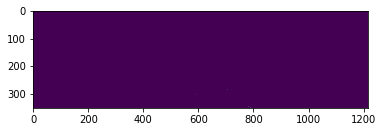

In [4]:
frame_id = 0
XYZ_list = []
while (frame_id < num_frames) : 
    depth = torch.from_numpy(lidar_frames[frame_id,:,:,0])
    XYZ = tc.calcCamPoints(depth).view(-1,3).t()
    XYZ_list.append(XYZ.type(torch.DoubleTensor))
    frame_id += 1

i = len(T_list)-1
T_intermToLast = [T_list[i]]
while (i>0) :
    T_temp = np.matmul(T_intermToLast[0],T_list[i-1])
    T_intermToLast.insert(0,T_temp)
    i -= 1

frame_id = 0
XYZ_concat_list = []
# while (frame_id < num_frames-1) : 
#     T = T_intermToLast[frame_id]
#     R_temp = torch.from_numpy(T[:3,:3])
    
#     XYZ = XYZ_list[frame_id]
    
#     t_temp = torch.from_numpy(T[:3,3]).expand(XYZ.shape[1],3).t()
    
#     XYZ_temp = torch.matmul(R_temp, XYZ) # rotated

#     XYZ_temp = XYZ_temp + t_temp
#     print("XYZ updated ")
#     print(XYZ_temp)
    
#     XYZ_concat_list.append(XYZ_temp)
#     frame_id += 1

print(XYZ_list[len(XYZ_list)-1].shape)
XYZ_concat_list.append(XYZ_list[len(XYZ_list)-1])
XYZ_finalFrame = torch.cat(XYZ_concat_list,-1)
print(XYZ_finalFrame.shape)

X = XYZ_finalFrame[0,:]
Y = XYZ_finalFrame[1,:]
Z = XYZ_finalFrame[2,:]

U = ((X*tc.fu)/Z + tc.cu).numpy().astype(int)
V = ((Y*tc.fv)/Z + tc.cv).numpy().astype(int)
print(U.shape)
print(U)

ind = np.where(V<tc.height)
print('ind shape ',ind[0].shape)
U = U[ind]
V = V[ind]
Z = Z[ind]
print('U shape ',U.shape)

ind = np.where(V>=0)
U = U[ind]
V = V[ind]
Z = Z[ind]
print(U.shape)

ind = np.where(U<tc.width)
U = U[ind]
V = V[ind]
Z = Z[ind]
print(U.shape)

ind = np.where(U>=0)
U = U[ind]
V = V[ind]
Z = Z[ind].numpy()
print(U.shape)

ind = np.where(Z>=0)
U = U[ind]
V = V[ind]
Z = Z[ind]

print(U.shape)
print(V.shape)
print(Z.shape)

print(Z)

concat_depth = np.zeros((tc.height, tc.width))
concat_depth[V,U] = Z

plt.imshow(concat_depth)
plt.show()
concat_depth = torch.from_numpy(concat_depth)


0


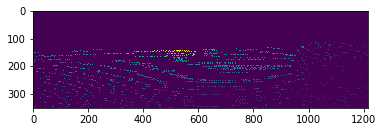

1


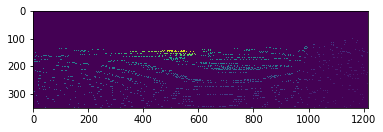

2


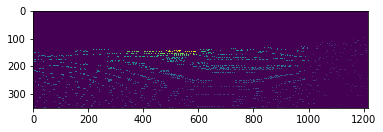

3


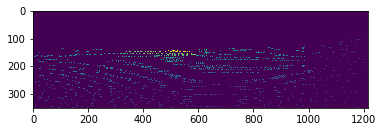

4


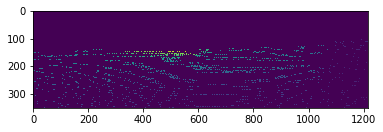

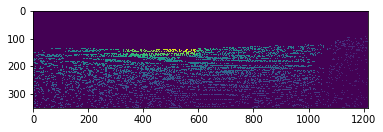

In [46]:
frame_id = 0
pts3_tempList = []
while (frame_id < num_frames) :
    depth = lidar_frames[frame_id,:,:,0]
    nc = npCloud(K,depth.shape[0],depth.shape[1])
    pts3 = nc.calcCamPoints(depth)
    pts3_tempList.append(pts3)
    frame_id += 1
    
i = len(T_list)-1
T_intermToLast = [T_list[i]]
while (i>0) :
    T_temp = np.matmul(T_intermToLast[0],T_list[i-1])
    T_intermToLast.insert(0,T_temp)
    i -= 1

frame_id = 0
pts3_concatenated = np.asarray([]).reshape(3,0)
while (frame_id < num_frames-1): 
    pts3 = pts3_tempList[frame_id]
    pts3 = np.vstack((pts3,np.ones((1,pts3.shape[1])))) # converting to homogeneous coordinates
    T = T_intermToLast[frame_id]
    pts3 = np.matmul(T,pts3)
    pts3_concatenated = np.hstack((pts3_concatenated,pts3[:3,:]))
    frame_id += 1

pts3_concatenated = np.hstack((pts3_concatenated,pts3_tempList[num_frames-1][:3,:]))
depth_concatenated = np.zeros(lidar_frames[0,:,:,0].shape)

pts2 = np.matmul(K,pts3_concatenated)
pts2[:2,:] /= pts2[2,:]
u = pts2[0,:].astype(np.int)
v = pts2[1,:].astype(np.int)
z = pts2[2,:]

idx = np.where(u<nc.width)
u = u[idx]
v = v[idx]
z = z[idx]

idx = np.where(v<nc.height)
u = u[idx]
v = v[idx]
z = z[idx]

idx = np.where(u>=0)
u = u[idx]
v = v[idx]
z = z[idx]

idx = np.where(v>=0)
u = u[idx]
v = v[idx]
z = z[idx]

depth_concatenated[v,u] = z

for i in range(num_frames):
    print(i)
    plt.imshow(lidar_frames[i,:,:,0])
    plt.show()
    
plt.imshow(depth_concatenated)
plt.show()


In [11]:
1092*6.37109375
np.ones((3,1))

# file_dir = './depth_selection/KITTI/calib/'+scene_date+'/calib_cam_to_cam.txt'
# f_dir = os.path.join(file_dir)
# f = open(f_dir)
# lines = f.readlines()
# lines[33]

array([[1.],
       [1.],
       [1.]])

## Using ground truth as the Lidar image input

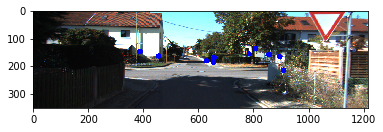

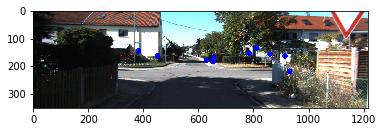

Total points :  10
Solution found :  True
T (from solvePnPRansac) : 
[[ 9.99999794e-01  6.42436798e-04 -1.61048994e-06 -4.52943116e-02]
 [-6.42434902e-04  9.99999310e-01  9.83915225e-04 -5.91498442e-02]
 [ 2.24259218e-06 -9.83913988e-04  9.99999516e-01  6.61284942e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T (from scipy least_squares) : 
[[ 9.99996918e-01 -2.28005529e-03  9.82052427e-04 -4.45099676e-02]
 [ 2.27844480e-03  9.99996063e-01  1.63793577e-03 -5.81696743e-02]
 [-9.85783145e-04 -1.63569317e-03  9.99998176e-01  6.61424964e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


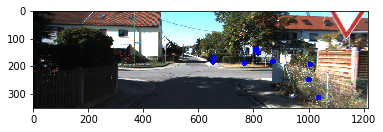

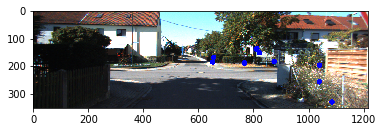

Total points :  10
Solution found :  False
T (from solvePnPRansac) : 
[[-0.50787773  0.6031544  -0.6150325   3.08232814]
 [ 0.32245794 -0.5289459  -0.78500771 -4.62349208]
 [-0.79879978 -0.59701005  0.07414792  2.30397923]
 [ 0.          0.          0.          1.        ]]


/home/jovyan/work/odometry_functions_depthcompletion_dataset.py:43: RuntimeWarning: invalid value encountered in true_divide
  pred_pts_2d_2[i] = pred_pts_2d_2[i]/pred_pts_2d_2[i][-1]


ValueError: Residuals are not finite in the initial point.

In [4]:
frame_id = 0
while (frame_id < 4) :
    features = find_keypoints(img_frames[frame_id,:,:,:],gt_frames[frame_id,:,:,0],feature_params)
    # print(type(features))
    next_features, status, error = track_features(img_frames[frame_id,:,:,:],features,img_frames[frame_id+1,:,:,:],lk_params)
    features = features[status==1]
    next_features = next_features[status==1]
    # print("Num features : ",len(features))

    image = np.copy(img_frames[frame_id,:,:,:])
    next_image = np.copy(img_frames[frame_id+1,:,:,:])
    for i in range(len(features)):
        cv2.circle(image,(features[i][0],features[i][1]),10,(0,0,255),-1)
        cv2.circle(next_image,(next_features[i][0],next_features[i][1]),10,(0,0,255),-1)

    plt.imshow(image)
    plt.show()

    plt.imshow(next_image)
    plt.show()

    scene=data_loader.img_path[index_list[0]].split('/')[5].split('_')[:3]
    scene_date = scene[0]
    camera_id = data_loader.img_path[index_list[0]].split('/')[-3]
    for i in range(1,len(scene)) : 
        scene_date += '_' + scene[i]
    K = get_calib_file(scene_date,camera_id) # eg: 2011_09_26, image_03
    pts_3d_1 = compute_3D_points(gt_frames[0,:,:,:],features,K)

    # print(pts_3d_1)

    pts_2d_2 = []
    for i in range(len(features)):
        x = int(next_features[i,0])
        y = int(next_features[i,1])
        pts_2d_2.append([x,y])
    pts_2d_2 = np.asarray(pts_2d_2)
    # print(pts_3d_1)
    print("Total points : ",len(pts_2d_2))
    # print(pts_2d_2)
    P = np.hstack((K,np.zeros((3,1))))

    pts_3d_1 = np.expand_dims(pts_3d_1.astype(np.float32),axis=1)
    pts_2d_2 = np.expand_dims(pts_2d_2.astype(np.float32),axis=1)
    ret = cv2.solvePnPRansac(pts_3d_1,pts_2d_2,P[:3,:3],distCoeffs=None)

    print("Solution found : ",ret[0])

    r = genEulerZXZMatrix(ret[1][0][0],ret[1][1][0],ret[1][2][0])
    transf_matrix = np.hstack((r,-ret[2]))
    transf_matrix = np.vstack((transf_matrix,np.asarray([0,0,0,1])))
    print("T (from solvePnPRansac) : ")
    print(transf_matrix)

    pts_3d_1 = np.hstack( (np.squeeze(pts_3d_1), np.ones(( len(pts_3d_1),1) )))
    pts_2d_2 = np.hstack( (np.squeeze(pts_2d_2), np.ones(( len(pts_2d_2),1) )))


    dSeed = np.zeros(len(pts_3d_1))
    opt = least_squares(func,dSeed,method='lm',verbose=0,args=(pts_3d_1,pts_2d_2,P))
    R = genEulerZXZMatrix(opt.x[0],opt.x[1],opt.x[2])
    t = np.asarray([[opt.x[3]],[opt.x[4]],[opt.x[5]]])
    T = np.hstack((R,t))
    T = np.vstack((T,np.asarray([[0,0,0,1]])))
    print("T (from scipy least_squares) : ")
    print(T)
    frame_id += 1

In [12]:
print(P)
print(pts_3d_1[0])
np.matmul(P,pts_3d_1[0])
p = [1,2]
p[-1]
print(data_loader.index)

[[903.5972   0.     697.9803   0.    ]
 [  0.     897.9356 239.2935   0.    ]
 [  0.       0.       1.       0.    ]]
[ 2.28702211 -1.71036708 29.94140625  1.        ]
42389


## Using Dilated Depth img

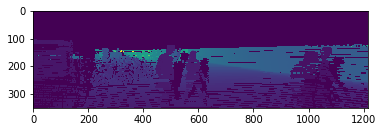

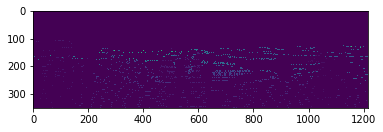

Num features :  10


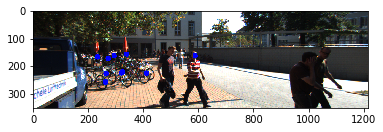

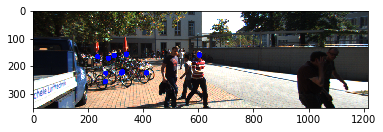

Total points :  10
Solution found :  True
T (from solvePnPRansac) : 
[[ 9.99995497e-01 -3.00083684e-03  5.29031053e-06 -1.24530878e-01]
 [ 3.00082694e-03  9.99994582e-01  1.35285625e-03  1.27775460e-02]
 [-9.34998275e-06 -1.35283428e-03  9.99999085e-01  2.54608756e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T (from scipy least_squares) : 
[[ 0.9999752   0.00691388  0.00133934 -0.12409845]
 [-0.00690859  0.99996847 -0.00391509  0.01264067]
 [-0.00136637  0.00390574  0.99999144  0.25482663]
 [ 0.          0.          0.          1.        ]]


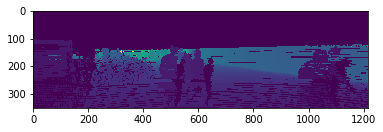

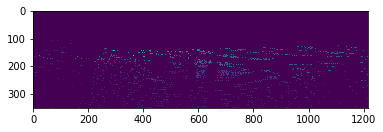

Num features :  10


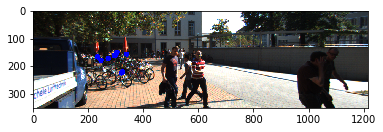

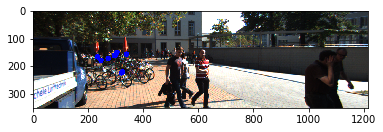

Total points :  10
Solution found :  True
T (from solvePnPRansac) : 
[[ 9.99999934e-01 -3.62994351e-04  2.51758254e-08  1.12503012e-02]
 [ 3.62994316e-04  9.99999865e-01  3.71564376e-04 -3.39295296e-05]
 [-1.60051592e-07 -3.71564343e-04  9.99999931e-01 -3.55534146e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T (from scipy least_squares) : 
[[ 9.99999838e-01  4.30456015e-04  3.71517108e-04  1.12359155e-02]
 [-4.30430838e-04  9.99999905e-01 -6.78457999e-05 -3.42428545e-05]
 [-3.71546277e-04  6.76858765e-05  9.99999929e-01 -3.55543798e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


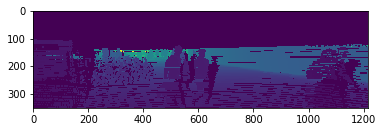

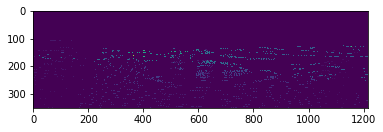

Num features :  10


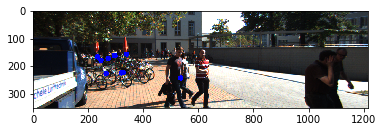

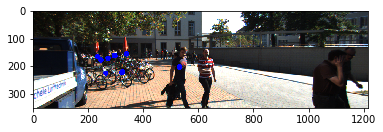

Total points :  10
Solution found :  True
T (from solvePnPRansac) : 
[[-0.29726837 -0.90594183  0.3014978  -5.86272186]
 [ 0.95216093 -0.30471567  0.02319307 -1.36266985]
 [ 0.07085953  0.29396899  0.95318474 14.42419427]
 [ 0.          0.          0.          1.        ]]
T (from scipy least_squares) : 
[[ 0.99445621 -0.10415659 -0.01443077  0.05911359]
 [ 0.10468949  0.99356964  0.0431218   0.07547801]
 [ 0.00984656 -0.04439349  0.9989656   0.09510609]
 [ 0.          0.          0.          1.        ]]


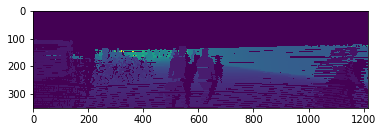

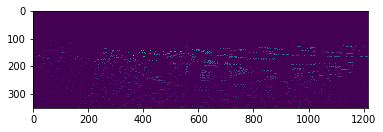

Num features :  10


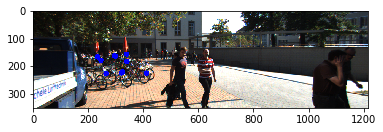

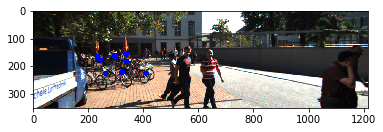

Total points :  10
Solution found :  True
T (from solvePnPRansac) : 
[[ 9.99999737e-01 -7.25731321e-04  5.16096171e-08  1.36647535e-02]
 [ 7.25731323e-04  9.99999734e-01 -6.82021923e-05 -6.46110885e-03]
 [-2.11313628e-09  6.82022118e-05  9.99999998e-01 -6.73713929e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T (from scipy least_squares) : 
[[ 9.99999997e-01 -3.09622519e-05 -6.82084187e-05  1.36661918e-02]
 [ 3.10138581e-05  9.99999713e-01  7.56723970e-04 -6.46581243e-03]
 [ 6.81849693e-05 -7.56726083e-04  9.99999711e-01 -6.73329924e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [5]:
frame_id = 0
while (frame_id < 4) : 
    lidar_frames[frame_id,500:700,100:,0] = 0
    depth_img = lidar_frames[frame_id,:,:,0]
    depth_inverted = np.where(depth_img>0,100-depth_img,0)
    depth_dilated = cv2.dilate(depth_inverted,np.ones((5,5),np.uint8))
    depth_dilated = np.where(depth_dilated>0,100-depth_dilated,0)
    depth_dilated = np.expand_dims(depth_dilated,-1)

    lidar_frames[frame_id+1,500:700,100:,0] = 0
    depth_img = lidar_frames[frame_id+1,:,:,0]
    depth_inverted = np.where(depth_img>0,100-depth_img,0)
    depth_dilated2 = cv2.dilate(depth_inverted,np.ones((5,5),np.uint8))
    depth_dilated2 = np.where(depth_dilated2>0,100-depth_dilated2,0)
    depth_dilated2 = np.expand_dims(depth_dilated2,-1)
    
    plt.imshow(np.squeeze(depth_dilated))
    plt.show()

    plt.imshow(depth_img)
    plt.show()

    features = find_keypoints(img_frames[frame_id,:,:,:],depth_dilated,feature_params)
    next_features, status, error = track_features(img_frames[frame_id,:,:,:],features,img_frames[frame_id+1,:,:,:],lk_params)
    features = features[status==1]
    next_features = next_features[status==1]
#     features1, features2 = match_keypoints(img_frames[frame_id,:,:,:],depth_dilated, img_frames[frame_id+1,:,:,:])
    print("Num features : ",len(features))

    image = np.copy(img_frames[frame_id,:,:,:])
    next_image = np.copy(img_frames[frame_id+1,:,:,:])
    for i in range(len(features)):
        cv2.circle(image,(features[i][0],features[i][1]),10,(0,0,255),-1)
        cv2.circle(next_image,(next_features[i][0],next_features[i][1]),10,(0,0,255),-1)

    plt.imshow(image)
    plt.show()

    plt.imshow(next_image)
    plt.show()

    scene=data_loader.img_path[index_list[0]].split('/')[5].split('_')[:3]
    scene_date = scene[0]
    camera_id = data_loader.img_path[index_list[0]].split('/')[-3]
    for i in range(1,len(scene)) : 
        scene_date += '_' + scene[i]
    K = get_calib_file(scene_date,camera_id) # eg: 2011_09_26, image_03
    pts_3d_1 = compute_3D_points(depth_dilated,features,K)

    # print(pts_3d_1)

    pts_2d_2 = []
    for i in range(len(features)):
        x = int(next_features[i,0])
        y = int(next_features[i,1])
        pts_2d_2.append([x,y])
    pts_2d_2 = np.asarray(pts_2d_2)
    # print(pts_3d_1)
    print("Total points : ",len(pts_2d_2))
    # print(pts_2d_2)
    P = np.hstack((K,np.zeros((3,1))))

    pts_3d_1 = np.expand_dims(pts_3d_1.astype(np.float32),axis=1)
    pts_2d_2 = np.expand_dims(pts_2d_2.astype(np.float32),axis=1)
    ret = cv2.solvePnPRansac(pts_3d_1,pts_2d_2,P[:3,:3],distCoeffs=None)

    print("Solution found : ",ret[0])

    r = genEulerZXZMatrix(ret[1][0][0],ret[1][1][0],ret[1][2][0])
    transf_matrix = np.hstack((r,-ret[2]))
    transf_matrix = np.vstack((transf_matrix,np.asarray([0,0,0,1])))
    print("T (from solvePnPRansac) : ")
    print(transf_matrix)

    pts_3d_1 = np.hstack( (np.squeeze(pts_3d_1), np.ones(( len(pts_3d_1),1) )))
    pts_2d_2 = np.hstack( (np.squeeze(pts_2d_2), np.ones(( len(pts_2d_2),1) )))


    dSeed = np.zeros(len(pts_3d_1))
    opt = least_squares(func,dSeed,method='lm',verbose=0,args=(pts_3d_1,pts_2d_2,P))
    R = genEulerZXZMatrix(opt.x[0],opt.x[1],opt.x[2])
    t = np.asarray([[opt.x[3]],[opt.x[4]],[opt.x[5]]])
    T = np.hstack((R,t))
    T = np.vstack((T,np.asarray([[0,0,0,1]])))
    print("T (from scipy least_squares) : ")
    print(T)
    frame_id += 1

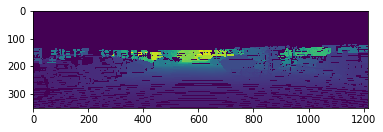

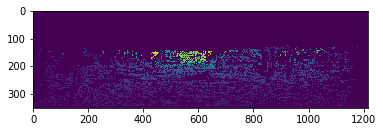

0.33233410009179915
1.2476136400040834
0.7745958579555635


In [23]:
gt = gt_frames[0,:,:,0]
depth = lidar_frames[0,:,:,0]

depth_dilated = cv2.dilate(lidar_frames[0,:,:,:],np.ones((5,5),np.uint8))
plt.imshow(depth_dilated)
plt.show()
plt.imshow(gt_frames[0,:,:,0])
plt.show()

gt_mask = np.where(gt!=0,1,0)
depth_mask = np.where(depth!=0,1,0)
dDepth_mask = np.where(depth_dilated!=0,1,0)

diff_gt_depth = gt_mask * depth_mask * (gt - depth)
diff_gt_depth *= diff_gt_depth
print(np.sqrt(np.mean(diff_gt_depth)))

diff_gt_dDepth = gt_mask * dDepth_mask * (gt - depth_dilated)
diff_gt_dDepth *= diff_gt_dDepth
print(np.sqrt(np.mean(diff_gt_dDepth)))

diff_depth_dDepth = depth_mask * dDepth_mask * (depth - depth_dilated)
diff_depth_dDepth *= diff_depth_dDepth
print(np.sqrt(np.mean(diff_depth_dDepth)))

# inverted depth : 

depth_inverted = np.where(depth>0,100-depth,0)

depth_dilated = cv2.dilate(depth_inverted,np.ones((5,5),np.uint8))

depth_dilated = np.where(depth_dilated>0,100-depth_dilated,0)
plt.imshow(depth_dilated)
plt.show()

gt_mask = np.where(gt!=0,1,0)
depth_mask = np.where(depth!=0,1,0)
dDepth_mask = np.where(depth_dilated!=0,1,0)

diff_gt_depth = gt_mask * depth_mask * (gt - depth)
diff_gt_depth *= diff_gt_depth
print(np.sqrt(np.mean(diff_gt_depth)))

diff_gt_dDepth = gt_mask * dDepth_mask * (gt - depth_dilated)
diff_gt_dDepth *= diff_gt_dDepth
print(np.sqrt(np.mean(diff_gt_dDepth)))

diff_depth_dDepth = depth_mask * dDepth_mask * (depth - depth_dilated)
diff_depth_dDepth *= diff_depth_dDepth
print(np.sqrt(np.mean(diff_depth_dDepth)))
